<a href="https://colab.research.google.com/github/Bziukiewicz/tests/blob/master/wpw_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalacja oraz import bibliotek

In [58]:
pip install ecg_plot


In [59]:
pip install wfdb

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from keras.preprocessing.sequence import pad_sequences
import scipy.io
import csv
import ecg_plot
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
import plotly.express as px
%load_ext autoreload
%autoreload
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Załadowanie danych z EKG dla pacjentów zdrowych, oraz zdiagnozowanych z WPW

In [62]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

In [63]:
def import_ecg_data(directory, ecg_len = 5000, trunc="post", pad="post"):
    print("Starting ECG import..")
    ecgs = []
    for ecgfilename in tqdm(sorted(os.listdir(directory))):
        filepath = directory + os.sep + ecgfilename
        if filepath.endswith(".mat"):
            data, header_data = load_challenge_data(filepath)
            data = pad_sequences(data, maxlen=ecg_len, truncating=trunc,padding=pad)
            ecgs.append(data)
    print("Finished!")
    return np.asarray(ecgs)

In [64]:
wpw_dir = "/content/drive/MyDrive/wpw_dataset"
wpw = import_ecg_data(wpw_dir)
normal_dir= '/content/drive/MyDrive/only_sinus_smaller'
normal=import_ecg_data(normal_dir)

Starting ECG import..


100%|██████████| 320/320 [00:04<00:00, 73.82it/s] 


Finished!
Starting ECG import..


100%|██████████| 1028/1028 [00:37<00:00, 27.33it/s]


Finished!


### Przykłady EKG dla pacjentów zdrowych, oraz ze zdiagnozowanym WPW

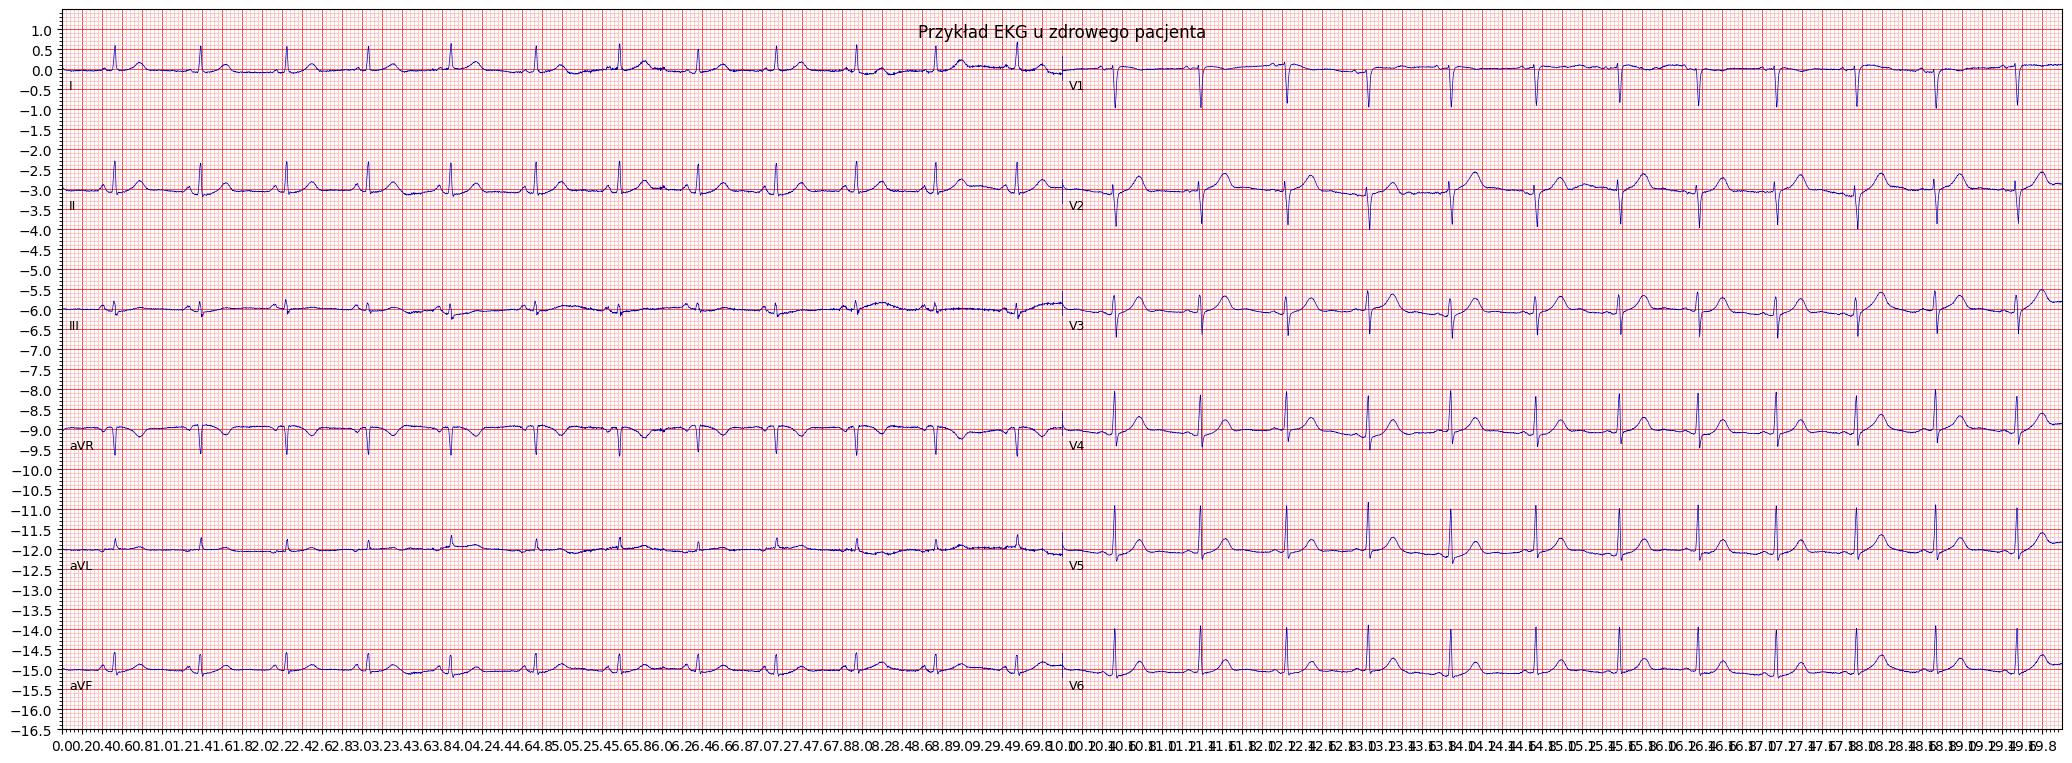

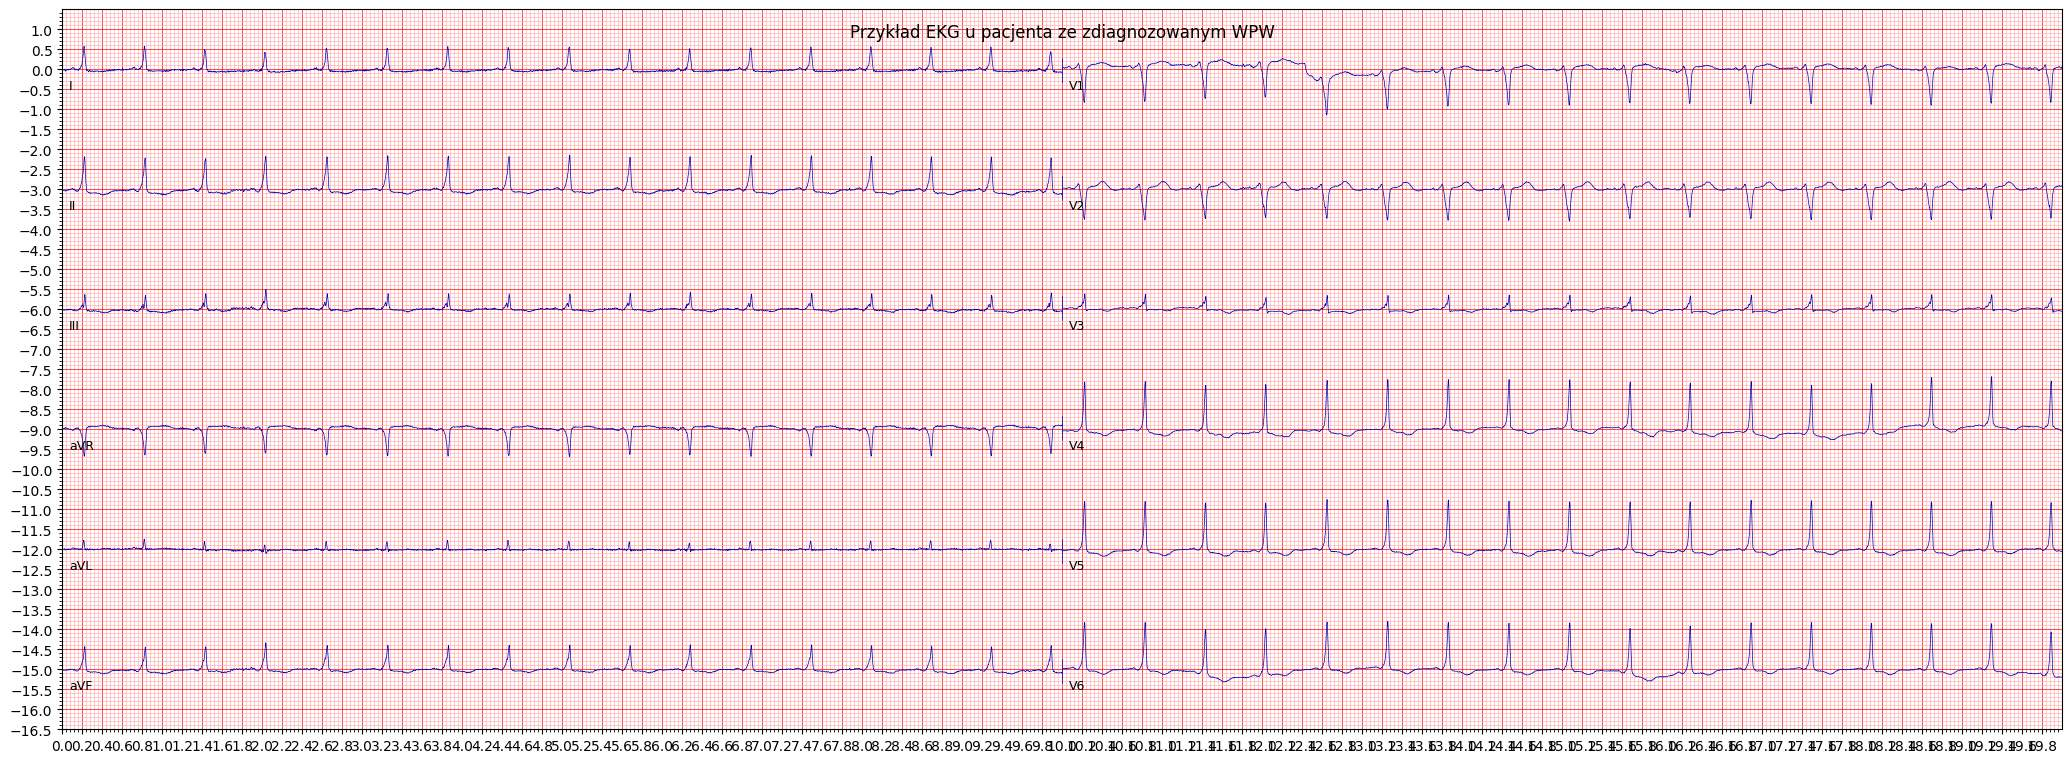

In [65]:
ecg_data = load_challenge_data('/content/drive/MyDrive/only_sinus_smaller/JS41028.mat')
ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='Przykład EKG u zdrowego pacjenta')
ecg_plot.show()

ecg_data = load_challenge_data('/content/drive/MyDrive/wpw_dataset/E03231.mat')
ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='Przykład EKG u pacjenta ze zdiagnozowanym WPW')
ecg_plot.show()

### Załądowanie pozostałych danych z pliku .hea

In [66]:
import scipy.io
import csv


folder_path = "/content/drive/MyDrive/wpw_dataset"

# Funkcja do otwierania plików MAT i HEA oraz łączenia danych w jednym wierszu
def process_files(mat_file_path, hea_file_path):

    mat_data = scipy.io.loadmat(mat_file_path)
    ekg_data = mat_data['val']


    with open(hea_file_path, 'r') as file:
        data = file.readlines()
        age = None
        sex = None
        diagnosis = None
        for line in data:
            if line.startswith('#Age:'):
                age = line.split(': ')[1].strip()
            elif line.startswith('#Sex:'):
                sex = line.split(': ')[1].strip()
            elif line.startswith('#Dx:'):
                diagnosis = line.split(': ')[1].strip()

    return ekg_data, age, sex, diagnosis

# Funkcja do zapisywania danych do pliku CSV
def save_to_csv(data, csv_file):
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

# Lista do przechowywania wszystkich danych EKG, metadanych i diagnoz
all_data = []

# Iteracja przez pliki w folderze
for file_name in os.listdir(folder_path):
    if file_name.endswith('.mat'):
        mat_file_path = os.path.join(folder_path, file_name)
        hea_file_path = os.path.join(folder_path, file_name.replace('.mat', '.hea'))

        ekg_data, age, sex, diagnosis = process_files(mat_file_path, hea_file_path)


        all_data.append([file_name] + [age, sex, diagnosis] + [ekg_data])


csv_file_path = "wszystkie_dane1.csv"
save_to_csv(all_data, csv_file_path)

In [67]:
df= pd.read_csv('/content/wszystkie_dane1.csv', names=['wiek','Płeć' ,'Diagnoza', 'dane'])

### Rozkład danych ze względu na wiek i płeć pacjenta

In [68]:
fig = px.histogram(df, x='wiek', title='Histogram rozkładu wieku',
                   labels={'wiek': 'Wiek', 'count': 'Liczba przypadków'})

fig.show()

In [69]:
df['Płeć'] = df['Płeć'].replace('M', 'Male')
df['Płeć'] = df['Płeć'].replace('male', 'Male')
fig = px.histogram(df, x='Płeć', title='Histogram rozkładu płci',
                   labels={'Płeć': 'Płeć', 'count': 'Liczba przypadków'})

fig.show()

### Przygotowanie danych do pracy

In [70]:
!pip install neurokit2


***Preprocessing***
1. Filtrowanie: W funkcji process_ecgs, sygnały EKG są najpierw czyszczone za pomocą funkcji nk.ecg_clean(), która wykorzystuje metody neurokit2 do eliminacji szumów i artefaktów z sygnału.

2. Normalizacja: Proces segmentacji i obliczania mediany dla sygnałów odgrywa tutaj funkcje normalizacji, ponieważ mediany są obliczane dla każdego sygnału EKG.

3. Segmentacja: Segmentacja jest wykonywana za pomocą funkcji nk.ecg_segment(), która dzieli sygnał na poszczególne cykle serca na podstawie znalezionych szczytów (r_peaks).

In [71]:

import neurokit2 as nk  # Import neurokit2 as nk

def resample_beats(beats):
    # Funkcja resample_beats dokonuje resamplingu zbioru szczytów do długości 250 próbek
    return np.array([np.nan_to_num(signal.resample(np.asarray(i), 250)) for i in beats])

def median_beat(beat_dict):
    # Funkcja median_beat oblicza medianę zbioru szczytów dla każdego słownika w zestawie
    beats = [entry['Signal'] for entry in beat_dict.values()]
    rsmp_beats = resample_beats(beats)
    return np.median(rsmp_beats, axis=0)

def process_ecgs(raw_ecg):
    # Funkcja process_ecgs przetwarza surowe dane EKG
    processed_ecgs = []
    for lead_set in tqdm(raw_ecg):
        twelve_leads = []
        leadII = lead_set[1]
        leadII_clean = nk.ecg_clean(leadII, sampling_rate=500, method="neurokit")  # Czyszczenie sygnału EKG
        r_peaks = nk.ecg_findpeaks(leadII_clean, sampling_rate=500, method="neurokit", show=False)  # Znajdowanie szczytów
        for lead in lead_set:
            try:
                beats = nk.ecg_segment(lead, rpeaks=r_peaks['ECG_R_Peaks'], sampling_rate=500, show=False)  # Segmentacja sygnału EKG
                med_beat = median_beat(beats)  # Obliczanie mediany dla sygnałów
            except:
                med_beat = np.ones(250) * np.nan
            twelve_leads.append(med_beat)
        processed_ecgs.append(twelve_leads)
    return np.array(processed_ecgs)

wpw_ecg= process_ecgs(wpw)

 56%|█████▌    | 89/160 [01:43<00:50,  1.42it/s]/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning:

Too few peaks detected to compute the rate. Returning empty vector.

 97%|█████████▋| 155/160 [02:35<00:04,  1.00it/s]/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning:

Too few peaks detected to compute the rate. Returning empty vector.

100%|██████████| 160/160 [02:38<00:00,  1.01it/s]


In [72]:
normal_ecg= process_ecgs(normal)

 99%|█████████▉| 509/514 [07:10<00:02,  1.79it/s]/usr/local/lib/python3.10/dist-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning:

Too few peaks detected to compute the rate. Returning empty vector.

100%|██████████| 514/514 [07:13<00:00,  1.19it/s]


***Porównnie danych dla jednej próbki przed preprocessingiem i po***

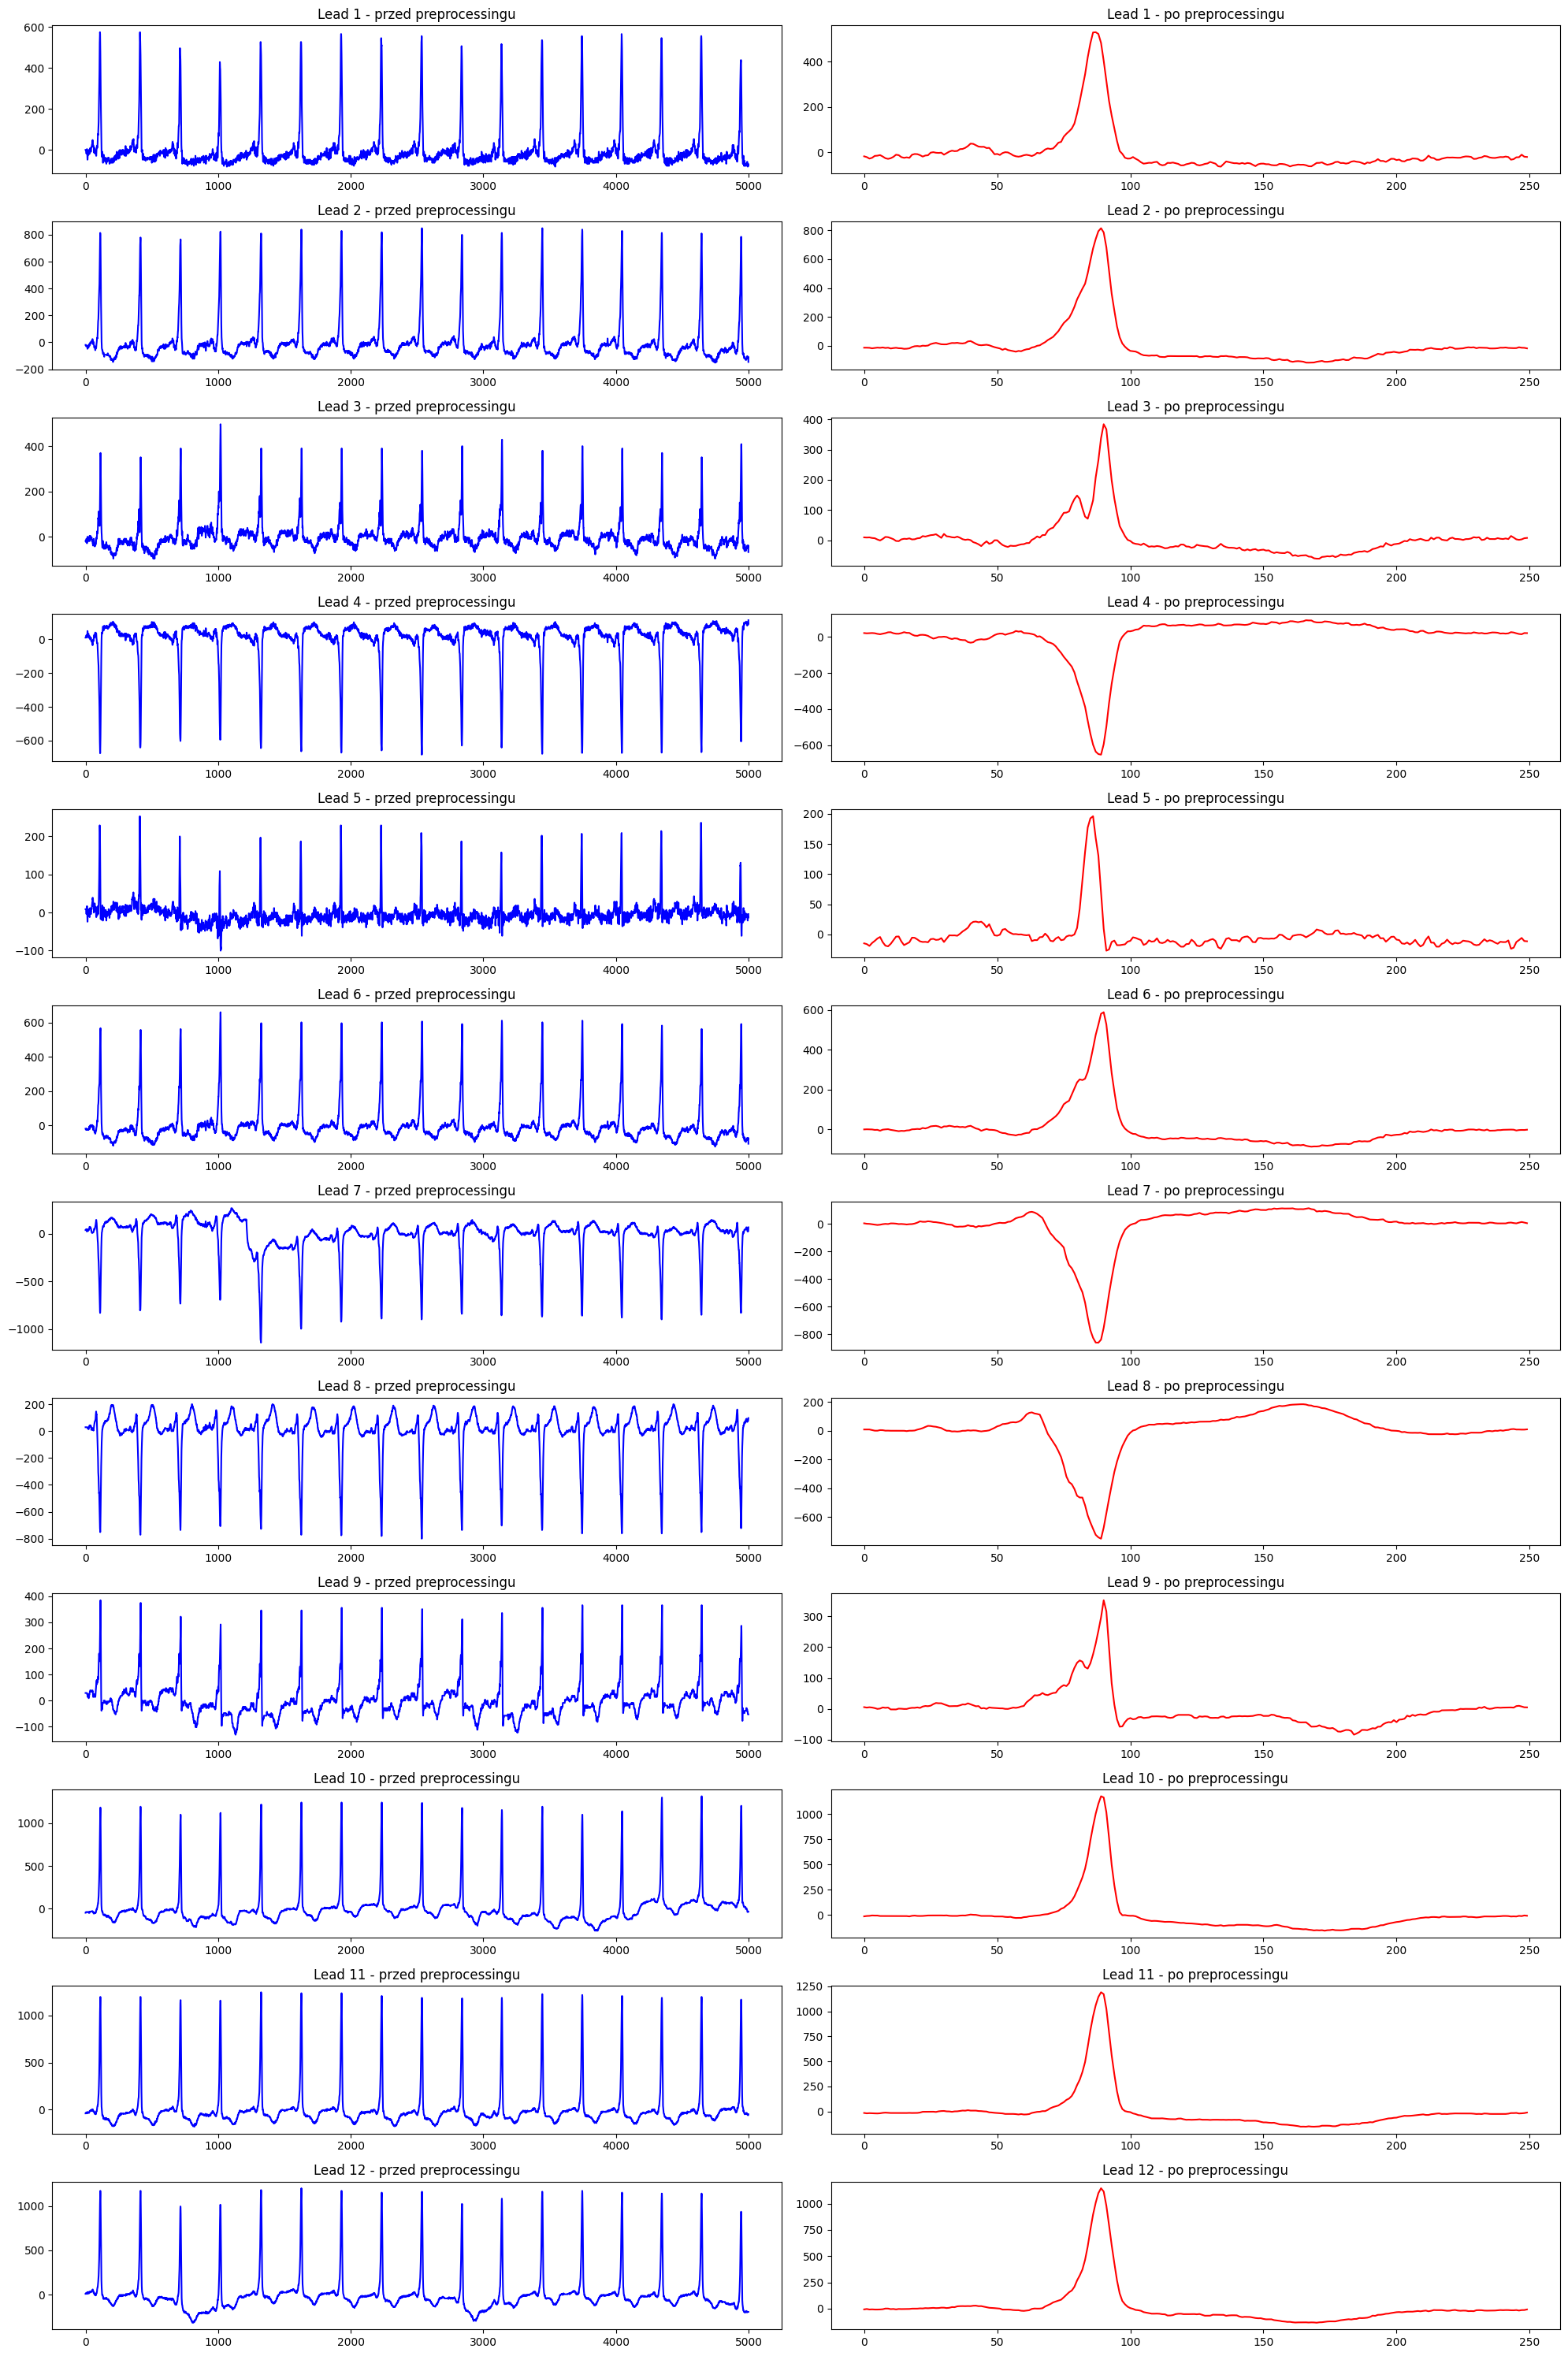

In [73]:

sample_index = 0
raw_sample = wpw[sample_index]
processed_sample = wpw_ecg[sample_index]


fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(20, 30))


for lead_index in range(12):

    raw_data = raw_sample[lead_index]
    processed_data = processed_sample[lead_index]


    axs[lead_index, 0].plot(raw_data, color='blue')
    axs[lead_index, 0].set_title(f'Lead {lead_index + 1} - przed preprocessingu')


    axs[lead_index, 1].plot(processed_data, color='red')
    axs[lead_index, 1].set_title(f'Lead {lead_index + 1} - po preprocessingu')


plt.tight_layout()


plt.show()

### Usuwanie wartości NAN
Jako, że wartości nan jest stosunkowo mało, usuwam całe próbki zawierające te wartości.

In [74]:
wpw_ecg[np.isnan(wpw_ecg)==True]

array([nan, nan, nan, ..., nan, nan, nan])

In [75]:
nan_indices = np.any(np.isnan(wpw_ecg), axis=(1, 2))
nan_sample_indices = np.where(nan_indices)[0]
print("Indeksy próbek zawierających wartości NaN:", nan_sample_indices)

Indeksy próbek zawierających wartości NaN: [ 89 155]


In [76]:
nan_indices = np.any(np.isnan(normal_ecg), axis=(1, 2))
nan_sample_indices = np.where(nan_indices)[0]
print("Indeksy próbek zawierających wartości NaN:", nan_sample_indices)

Indeksy próbek zawierających wartości NaN: [509 510]


In [77]:
wpw_ecg = np.delete(wpw_ecg, 89, axis=0)
wpw_ecg = np.delete(wpw_ecg, 155, axis=0)
normal_ecg = np.delete(normal_ecg, 509, axis=0)
normal_ecg = np.delete(normal_ecg, 510, axis=0)

In [78]:
nan_indices = np.any(np.isnan(wpw_ecg), axis=(1, 2))
nan_sample_indices = np.where(nan_indices)[0]
print("Indeksy próbek zawierających wartości NaN:", nan_sample_indices)

Indeksy próbek zawierających wartości NaN: [154]


In [79]:
wpw_ecg = np.delete(wpw_ecg, 154, axis=0)

In [80]:
nan_indices = np.any(np.isnan(normal_ecg), axis=(1, 2))
nan_sample_indices = np.where(nan_indices)[0]
print("Indeksy próbek zawierających wartości NaN:", nan_sample_indices)

Indeksy próbek zawierających wartości NaN: [509]


In [81]:
normal_ecg = np.delete(normal_ecg, 509, axis=0)

In [82]:
np.isnan(wpw_ecg).sum()

0

###Podział na dane testowe i treningowe, oraz dodanie wartości target

In [83]:
wpw_ecg = np.moveaxis(wpw_ecg, 1, -1)
normal_ecg = np.moveaxis(normal_ecg, 1, -1)

In [84]:
wpw_traget= np.ones(wpw_ecg.shape[0])
normal_traget= np.zeros(normal_ecg.shape[0])

In [85]:
wpw_ecg.shape

(157, 250, 12)

In [86]:
wpw_traget.shape


(157,)

In [87]:
# podział zbiorów na treningowy i testowy 30% to zbiór testowy
wpw_train = wpw_ecg[:117]
wpw_test = wpw_ecg[117:]
wpw_target_train = wpw_traget[:117]
wpw_target_test = wpw_traget[117:]
print(wpw_train .shape)
print(wpw_test.shape)
normal_train = normal_ecg[:383]
normal_test = normal_ecg[383:]
print(normal_train .shape)
print(normal_test.shape)
normal_target_train = normal_traget[:383]
normal_target_test = normal_traget[383:]

(117, 250, 12)
(40, 250, 12)
(383, 250, 12)
(128, 250, 12)


In [88]:
X_train = np.vstack([normal_train,wpw_train])
y_train = np.hstack([normal_target_train,wpw_target_train])

In [89]:
X_test = np.vstack([normal_test,wpw_test])
y_test = np.hstack([normal_target_test,wpw_target_test])

In [90]:
X_train.shape

(500, 250, 12)

In [91]:
y_train.shape

(500,)

In [92]:
X_test.shape

(168, 250, 12)

### Modele uczenia maszynowego

***Model lasów losowych***

In [93]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

In [94]:
from sklearn.metrics import accuracy_score

X_train_flatten = np.reshape(X_train, (500, -1))
X_test_flatten = np.reshape(X_test, (168, -1))

model_random_tree = classifier = RandomForestClassifier()
model_random_tree.fit(X_train_flatten, y_train)

y_pred_random_tree = model_random_tree.predict(X_test_flatten)
print(accuracy_score(y_test, y_pred_random_tree))


0.5238095238095238


In [95]:
param_grid = {
    'n_estimators': [1, 5, 10, 15, 20, 30,50 ,100, 200],
    'max_depth': [None, 1, 3, 5, 7, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['entropy', 'gini']
}

grid_search = GridSearchCV(estimator=model_random_tree,
                     param_grid=param_grid,
                     scoring='roc_auc')

grid_search.fit(X_train_flatten, y_train)

best_parameters = grid_search.best_params_
print(best_parameters)

{'criterion': 'gini', 'max_depth': 7, 'min_samples_split': 5, 'n_estimators': 50}


In [96]:
model_random_tree = RandomForestClassifier(**best_parameters)
model_random_tree.fit(X_train_flatten, y_train)
y_pred_random_tree = model_random_tree.predict(X_test_flatten)
print(accuracy_score(y_test, y_pred_random_tree))

0.5357142857142857


In [97]:
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
cm = confusion_matrix(y_test, y_pred_random_tree)

def plot_confusion_matrix(cm):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)

***Model Regresji logistycznej***

In [98]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression()
logistic_regression_model.fit(X_train_flatten, y_train)
y_pred_logistic_regression = logistic_regression_model.predict(X_test_flatten)
print(accuracy_score(y_test, y_pred_logistic_regression))

cm = confusion_matrix(y_test, y_pred_logistic_regression)

def plot_confusion_matrix(cm):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)


0.7619047619047619


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



***Model K-najbliższych sąsiadów***

In [99]:
from sklearn.neighbors import KNeighborsClassifier

kn_model = KNeighborsClassifier(n_neighbors=5)
kn_model.fit(X_train_flatten, y_train)
y_pred_kn = kn_model.predict(X_test_flatten)
print(accuracy_score(y_test, y_pred_kn))

cm = confusion_matrix(y_test, y_pred_kn)

def plot_confusion_matrix(cm):
    # klasyfikacja binarna
    cm = cm[::-1]
    cm = pd.DataFrame(cm, columns=['pred_0', 'pred_1'], index=['true_1', 'true_0'])

    fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
                                      colorscale='ice', showscale=True, reversescale=True)
    fig.update_layout(width=500, height=500, title='Confusion Matrix', font_size=16)
    fig.show()

plot_confusion_matrix(cm)

0.8452380952380952


***Model RNN- Rekurencyjna sieć neuronowa***

In [100]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, GRU, Lambda, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

# Definicja funkcji celu
def rnn_objective(params):
    rnn_model = Sequential()
    rnn_model.add(LSTM(units=params['units1'], input_shape=(250, 12), return_sequences=True))
    rnn_model.add(Dropout(params['dropout1']))
    rnn_model.add(LSTM(units=params['units2'], return_sequences=True))
    rnn_model.add(Dropout(params['dropout2']))
    rnn_model.add(LSTM(units=params['units3']))
    rnn_model.add(Dense(units=1, activation='sigmoid'))

    rnn_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

    # Dopasowanie modelu
    history = rnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)

    # Zwrócenie wartości do minimalizacji (np. błąd walidacji)
    return -history.history['val_accuracy'][-1]  # Minimizujemy walidacyjną dokładność

# Definicja przestrzeni hiperparametrów
space = {
    'units1': hp.choice('units1', [32, 64, 128]),
    'dropout1': hp.uniform('dropout1', 0, 0.5),
    'units2': hp.choice('units2', [32, 64, 128]),
    'dropout2': hp.uniform('dropout2', 0, 0.5),
    'units3': hp.choice('units3', [32, 64, 128])
}

# Uruchomienie optymalizacji bayesowskiej
trials = Trials()
best_params = fmin(fn=rnn_objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Najlepsze hiperparametry:", best_params)

 10%|█         | 1/10 [03:28<31:12, 208.03s/trial, best loss: -0.20000000298023224]

In [ ]:
best_rnn_model = Sequential()
best_rnn_model.add(LSTM(units=best_params['units1'], input_shape=(250, 12), return_sequences=True))
best_rnn_model.add(Dropout(best_params['dropout1']))
best_rnn_model.add(LSTM(units=best_params['units2'], return_sequences=True))
best_rnn_model.add(Dropout(best_params['dropout2']))
best_rnn_model.add(LSTM(units=best_params['units3']))
best_rnn_model.add(Dense(units=1, activation='sigmoid'))

best_rnn_model.compile(optimizer='adam',
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

history = best_rnn_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=0)

In [ ]:
results=best_rnn_model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {results[1]:.4f}')
print(f'Loss: {results[0]:.4f}')

In [ ]:
from hyperopt import fmin, tpe, hp, Trials
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization


def cnn_objective(params):
    model = Sequential()

    model.add(Conv1D(filters=params['filters1'], kernel_size=params['kernel_size1'], activation='relu', input_shape=(150, 12)))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=params['filters2'], kernel_size=params['kernel_size2'], activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=params['pool_size1']))
    model.add(Dropout(params['dropout1']))
    model.add(Conv1D(filters=params['filters3'], kernel_size=params['kernel_size3'], activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=params['pool_size2']))
    model.add(Dropout(params['dropout2']))
    model.add(Flatten())
    model.add(Dense(units=params['units'], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout3']))
    model.add(Dense(units=1, activation='sigmoid'))


    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split= 0.2, verbose=0)

    return -history.history['val_accuracy'][-1]


space = {
    'filters1': hp.choice('filters1', [64, 128]),
    'kernel_size1': hp.choice('kernel_size1', [5, 10]),
    'filters2': hp.choice('filters2', [64, 128]),
    'kernel_size2': hp.choice('kernel_size2', [10, 15]),
    'pool_size1': hp.choice('pool_size1', [2, 3]),
    'dropout1': hp.uniform('dropout1', 0, 0.3),
    'filters3': hp.choice('filters3', [128, 256]),
    'kernel_size3': hp.choice('kernel_size3', [3, 5, 7]),
    'pool_size2': hp.choice('pool_size2', [2, 3]),
    'dropout2': hp.uniform('dropout2', 0, 0.3),
    'units': hp.choice('units', [32, 64]),
    'dropout3': hp.uniform('dropout3', 0, 0.3)
}

trials = Trials()
best_params = fmin(fn=cnn_objective, space=space, algo=tpe.suggest, max_evals=10, trials=trials)

print("Najlepsze hiperparametry:", best_params)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=4)

In [ ]:
best_model = Sequential()

best_model.add(Conv1D(filters=best_params['filters1'], kernel_size=best_params['kernel_size1'], activation='relu', input_shape=(150, 12)))
best_model.add(BatchNormalization())
best_model.add(Conv1D(filters=best_params['filters2'], kernel_size=best_params['kernel_size2'], activation='relu'))
best_model.add(BatchNormalization())
best_model.add(MaxPooling1D(pool_size=best_params['pool_size1']))
best_model.add(Dropout(best_params['dropout1']))
best_model.add(Conv1D(filters=best_params['filters3'], kernel_size=best_params['kernel_size3'], activation='relu'))
best_model.add(BatchNormalization())
best_model.add(MaxPooling1D(pool_size=best_params['pool_size2']))
best_model.add(Dropout(best_params['dropout2']))
best_model.add(Flatten())
best_model.add(Dense(units=best_params['units'], activation='relu'))
best_model.add(BatchNormalization())
best_model.add(Dropout(best_params['dropout3']))
best_model.add(Dense(units=1, activation='sigmoid'))


best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
best_model.summary()

In [ ]:
history_cnn = best_model.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32, callbacks=[es])

In [ ]:
results_cnn=best_model.evaluate(X_test, y_test, verbose=0)
print(f'Accuracy: {results[1]:.4f}')
print(f'Loss: {results[0]:.4f}')